# Reverse engineering ngmix' gaussian moments - part 2

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import ngmix
import autometacal
import tensorflow as tf

Get a galaxy:

In [3]:
scale = .2
stamp_size=51
gal, psf = autometacal.data.galaxies.make_data(img_noise=0.0005,gal_g1=[0.],gal_g2=[0.5],scale=scale)

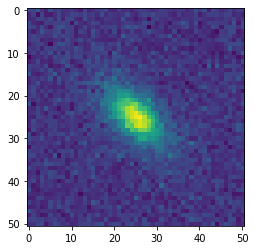

In [4]:
imshow(gal.numpy()[0])
obs=ngmix.Observation(gal.numpy()[0],jacobian=ngmix.DiagonalJacobian(row=25, col=25, scale=.2))

Set a fitter with Gaussian moments:

In [5]:
weight_fwhm = scale*stamp_size/2 # <- this sets everything for the window function
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
fitter._measure_moments(obs)

{'flags': 0,
 'npix': 2601,
 'wsum': 28.391886409860447,
 'sums': array([-0.00014082, -0.00075055,  0.00196324,  0.0283736 ,  0.05426553,
         0.03195314]),
 'sums_cov': array([[ 1.36575550e+00, -1.54954090e-18, -1.90131368e-16,
         -2.00238589e-17, -1.15060956e-17, -7.90294975e-18],
        [-2.41076165e-18,  1.36575550e+00, -2.89693738e-17,
         -5.68748743e-17, -8.08188016e-17, -1.94671994e-18],
        [-1.89264642e-16,  1.43853723e-17,  1.21351863e+01,
          2.98011602e-17,  4.72483448e-17,  2.22713847e-15],
        [-6.14268293e-18, -5.75253956e-17,  2.29164764e-17,
          1.26799874e+01, -3.73507648e-17, -3.52111596e-18],
        [-9.28348110e-18, -6.00800469e-17,  9.92976724e-17,
         -6.49979202e-17,  2.48151738e+01,  2.73151100e+00],
        [-7.90294975e-18, -1.94671994e-18,  2.22713847e-15,
         -3.52111596e-18,  2.73151100e+00,  5.88419538e-01]]),
 'pars': array([-0.00440716, -0.02348914,  0.06144117,  0.88797558,  1.69828491,
         0.7988284

In [6]:
pix_weights = ones([51,51])
jake=autometacal.tf_ngmix.make_diagonal_jacobian(25,25,scale=.2)
image = gal.numpy()[0]
pixels=autometacal.tf_ngmix.make_pixels(image,pix_weights,jake)
T = autometacal.tf_ngmix.fwhm_to_T(weight_fwhm)
weights = autometacal.tf_ngmix.create_gmix([0.,0.,0.,0.,T,1.],'gauss')
autometacal.tf_ngmix.get_moments(weights,pixels)

tf.Tensor(0.031953137, shape=(), dtype=float32) tf.Tensor(0.879863, shape=(), dtype=float32) tf.Tensor(0.8184219, shape=(), dtype=float32) tf.Tensor(0.44398776, shape=(), dtype=float32)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.03617834, 0.5228661 ], dtype=float32)>

In [7]:
weights

<tf.Tensor: shape=(1, 13), dtype=float32, numpy=
array([[29.471672  ,  0.        ,  0.        ,  4.6905622 ,  0.        ,
         4.6905622 , 22.001373  ,  1.        ,  0.21319406,  0.        ,
         0.21319406,  0.03393089,  1.        ]], dtype=float32)>

## Testing

In [20]:
def make_diagonal_jacobian(row0, col0, scale):
  """make a simple diagonal jacobian, defining centre & pixel scale"""
  
  jacob={'row0': row0,
  'col0': col0,
  'dvdrow': scale,
  'dvdcol': 0.0,
  'dudrow': 0.0,
  'dudcol': scale,
  'det': scale*scale,
  'scale': scale}

  return jacob

def jacobian_get_vu(jacob, row, col):
  """
  convert row,col to v,u using the input jacobian
  """

  rowdiff = row - jacob['row0']
  coldiff = col - jacob['col0']

  v = jacob['dvdrow']*rowdiff + jacob['dvdcol']*coldiff
  u = jacob['dudrow']*rowdiff + jacob['dudcol']*coldiff

  return v, u

def jacobian_get_area(jacob):
  """
  get the pixel area
  """
  
  return jacob['scale']**2

#####make "observation" - in our case, it's just the pixels. 
#####these don't need to be tfied

def make_pixels(image, weight, jacob, ignore_zero_weight=True):
  """
  make a pixel array from the image and weight
  stores v,u image value, and 1/err for each pixel
  parameters
  ----------
  pixels: array
      1-d array of pixel structures, u,v,val,ierr
  image: 2-d array
      2-d image array
  weight: 2-d array
      2-d image array same shape as image
  jacob: jacobian structure
      row0,col0,dvdrow,dvdcol,dudrow,dudcol,...
  ignore_zero_weight: bool
      If set, zero or negative weight pixels are ignored.  In this case the
      returned pixels array is equal in length to the set of positive weight
      pixels in the weight image.  Default True.
  returns
  -------
  1-d pixels array
  """

  if ignore_zero_weight:
    w = np.where(weight > 0.0)
    npixels = w[0].size
  else:
    npixels = image.size

  pixels = np.zeros(npixels, dtype=_pixels_dtype)

  fill_pixels(
    pixels,
    image,
    weight,
    jacob,
    ignore_zero_weight=ignore_zero_weight,
  )

  return tf.convert_to_tensor([[*x] for x in pixels],dtype=tf.float32)
  
  
def fill_pixels(pixels, image, weight, jacob, ignore_zero_weight=True):
    """
    store v,u image value, and 1/err for each pixel
    store into 1-d pixels array
    parameters
    ----------
    pixels: array
        1-d array of pixel structures, u,v,val,ierr
    image: 2-d array
        2-d image array
    weight: 2-d array
        2-d image array same shape as image
    jacob: jacobian structure
        row0,col0,dvdrow,dvdcol,dudrow,dudcol,...
    ignore_zero_weight: bool
        If set, zero or negative weight pixels are ignored.
        In this case it verified that the input pixels
        are equal in length to the set of positive weight
        pixels in the weight image.  Default True.
    """
    nrow, ncol = image.shape
    pixel_area = jacobian_get_area(jacob)

    ipixel = 0
    for row in range(nrow):
        for col in range(ncol):

            ivar = weight[row, col]
            if ignore_zero_weight and ivar <= 0.0:
                continue

            pixel = pixels[ipixel]

            v, u = jacobian_get_vu(jacob, row, col)

            pixel['v'] = v
            pixel['u'] = u
            pixel['area'] = pixel_area

            pixel['val'] = image[row, col]

            if ivar < 0.0:
                ivar = 0.0

            pixel['ierr'] = tf.math.sqrt(ivar)

            ipixel += 1
  
_pixels_dtype = [
  ("u", "f8"),
  ("v", "f8"),
  ("area", "f8"),
  ("val", "f8"),
  ("ierr", "f8"),
  ("fdiff", "f8"),
]

In [21]:
pix_weights = ones([51,51])
jake=autometacal.tf_ngmix.make_diagonal_jacobian(25,25,scale=.2)
image = gal.numpy()[0]
pixels=make_pixels(image,pix_weights,jake)
T = autometacal.tf_ngmix.fwhm_to_T(weight_fwhm)
weights = autometacal.tf_ngmix.create_gmix([0.,0.,0.,0.,T,1.],'gauss')
autometacal.tf_ngmix.get_moments(weights,pixels)

tf.Tensor(0.031953137, shape=(), dtype=float32) tf.Tensor(0.879863, shape=(), dtype=float32) tf.Tensor(0.8184219, shape=(), dtype=float32) tf.Tensor(0.44398776, shape=(), dtype=float32)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.03617834, 0.5228661 ], dtype=float32)>

In [18]:
gmix_eval_pixel_tf(weights,pixels)

<tf.Tensor: shape=(2601,), dtype=float32, numpy=
array([0.00019379, 0.00023882, 0.00029181, ..., 0.00029181, 0.00023882,
       0.00019379], dtype=float32)>

In [16]:
tf.size(image)

<tf.Tensor: shape=(), dtype=int32, numpy=2601>